In [ ]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0


In [ ]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 53 kB/s 
     |████████████████████████████████| 20.1 MB 11.8 MB/s 
     |████████████████████████████████| 459 kB 50.4 MB/s 
     |████████████████████████████████| 2.9 MB 39.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# **preparer la dataset** 


importer les packages nécessaire 


In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# Librairies tensorflow
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizer_v2.adam import Adam 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import glob
import cv2


 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Images de test et de train 

In [2]:
SIZE = 224  #Resize images
#savedModel = 'cnn_vgg16_model_trained_2.h5' # Le chemin du sauvegarde du réseau  

# Préparation des données d'entraînement et les étiquettes dans les listes respectives
beninImages = []
beninLabels = [] 
malinImages = []
malinLabels = [] 
for directory_path1 in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/*'):
  print(directory_path1)
  for directory_path in glob.glob(directory_path1+'/*'):
    s=0
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
      if label=="benin":
        s=s+1
        beninImages.append(img_path)
        beninLabels.append(label)
      else:
        malinImages.append(img_path)
        malinLabels.append(label)
        s=s+1
    print(s)
       


/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train
malin
427
benin
216
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test
malin
99
benin
53


In [3]:
def splitdata(porc,images,label,trainI,trainL,testI,testL):
  n=int((len(images)*porc)/100)
  for i in range(n):
   trainI.append(images[i])
   trainL.append(label[i])
 
  for i in range(n,len(images)):
   testI.append(images[i])
   testL.append(label[i])

In [4]:
len(beninImages),len(malinImages)

(269, 526)

In [5]:
def splitdata(porc,images,label,trainI,trainL,testI,testL):
  n=int((len(images)*porc)/100)
  print(n)
  for i in range(n):
   trainI.append(images[i])
   trainL.append(label[i])
  for i in range(len(images)-n):
   testI.append(images[i])
   testL.append(label[i])

In [6]:
trainImages=[]
testImages=[]
trainLabels=[]
testLabels=[]
porc=80
splitdata(porc,beninImages,beninLabels,trainImages,trainLabels,testImages,testLabels)
splitdata(porc,malinImages,malinLabels,trainImages,trainLabels,testImages,testLabels)


215
420


Organiser les images de test et de train dans des dataframes 

In [7]:
from sklearn.model_selection import train_test_split
trainImages, testImages, trainLabels, testLabels = train_test_split( trainImages+testImages, trainLabels+testLabels, test_size=0.2, random_state=80)

In [8]:
trainImages = np.array(trainImages)
trainLabels = np.array(trainLabels)
testImages = np.array(testImages)
testLabels = np.array(testLabels)


In [9]:
df_train = pd.DataFrame({"id": trainImages, "label": trainLabels})

In [10]:
df_test = pd.DataFrame({"id": testImages, "label": testLabels})

préparer les paramètres du modèle 

In [11]:

# Les chemins vers les jeu de données
TRAINING_DIR      = directory_path+'/jpeg/train'
TESTING_DIR       = directory_path+'/jpeg/test'

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 80     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 19     # Pour un VGG16 freeze de réapprentissage de certaines couches **19->Freezer les 5blocs ** 15->Freezer les 4blocs ** 11->Freeze les 3blocs ** 
                       # Pour EfficienNetB0 ------>  bloquer les 7 blocs=237,Bloquer les 6 blocs=221, bloquer les 5 blocs=162 
                       # Pour Resnet50 ------> 86 BLOC 4 ET 5 et 154 BLOCK 5.
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé
CLASS_NUMBER  = 2     # Nombre de classe en sortie
validation_split=0.3
DATA_AUG_BATCH_SIZE = 10

In [12]:
# ###### TRAIN #######
# # Nom du dossier qui contient les images augmentées
# aug_img_path = '/content/drive/MyDrive/PFE_M2/thyroid_aug/'

# # Créer un nouveau dossier pour enregistrer les images augmentées
# !mkdir -p /content/drive/MyDrive/PFE_M2/thyroid_aug/

# # Vérifiez si le dossier a été créé
# !ls -la /content/drive/MyDrive/PFE_M2/thyroid_aug/


In [13]:

# # Nombre d'étapes pour effectuer l'augmentation des données
# n_steps_data_aug = np.ceil(df_train.shape[0]/DATA_AUG_BATCH_SIZE
#                            ).astype(int)

# print("Batch size: ", DATA_AUG_BATCH_SIZE)
# print("Number of steps: ", n_steps_data_aug)

In [14]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255

train_datagen =  \
        ImageDataGenerator(
            # preprocessing_function=preprocess_input,
            # rotation_range =45,
            # width_shift_range=0.2,
            # height_shift_range=0.2,
            # shear_range=0.2,
            # horizontal_flip=True,
            # fill_mode ='reflect',
            validation_split=validation_split)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            directory=None,
            # save_to_dir=aug_img_path,
            # save_prefix='aug',
            # save_format='jpeg',
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            class_mode="categorical",
            batch_size= DATA_AUG_BATCH_SIZE,  # batch size for data augmentation
            subset="training",
            interpolation="nearest",
            validate_filenames=True)
train_labels = to_categorical(train_generator.classes)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 446 validated image filenames belonging to 2 classes.


In [15]:
valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            class_mode="categorical",
            batch_size=DATA_AUG_BATCH_SIZE,
            subset="validation",
            interpolation="nearest",
            validate_filenames=True)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 190 validated image filenames belonging to 2 classes.


In [16]:

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)    
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        has_ext=True, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

Found 159 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

**Après l'augmentation des données**

In [17]:

# # Exécuter le générateur de données
# # Nombre d'étapes pour effectuer l'augmentation des données

# for i in range(n_steps_data_aug):
#     next(train_generator)

In [18]:
# # Nombre d'images augmentées créées
# aug_file_nm = os.listdir(aug_img_path)
# number_files = len(aug_file_nm)
# print("Nombre de nouvelles images générées: {}".format(number_files))

# aug_file_nm = np.array(aug_file_nm)



In [19]:

# N_COLS = 5
# N_SAMPLES = 10
# n_rows = np.ceil(N_SAMPLES / N_COLS).astype(int)

# # Tracez les échantillons d'image d'origine
# print("Images originales")
# fig, axes = plt.subplots(n_rows, N_COLS, figsize=(15, 6))
# for i, ax in enumerate(axes.flatten()):
#     img_path=trainImages[i]
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     ax.imshow(img)
# plt.show()

# # # Tracez les images augmentées
# # print("\nImages augmentées")
# # fig, axes = plt.subplots(n_rows, N_COLS, figsize=(15, 6))
# # for i, ax in enumerate(axes.flatten()):
# #     aug_img_path=aug_file_nm[i]
# #     img = cv2.imread(aug_img_path, cv2.IMREAD_COLOR)
# #     ax.imshow(img)
# # plt.show()


# **VGG -16 code (avec les poids des images radiographique covid19)**


Importer les packages nécessaires pour VGG-16 + la Construction du MLP + RF + SVM

In [20]:

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Transfert** **progressif**  **TP**

**Importer le fichier contenant les poids du VGG-16 entraîné sur des images radiographique COVID-19** 

**1 - poids vgg (train le 5ème bloc de convolution sur des images radiograpique)**



In [21]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
load_pathVGG='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/vgg16_model_trained_covid19_TOUSLESBLOC.h5'     
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model = VGG16(include_top=False,input_shape=(IMGSIZE, IMGSIZE, 3),weights=None)



## VGG-16 (MLP)  

In [22]:
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dense(128, activation='relu', name='top-fc3')(x)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(4, activation='softmax', name='softmax')(x)
# Assemblage du modèle final
net_final_VGG = Model(inputs=base_model.input, outputs=output_layer)

In [23]:
net_final_VGG.load_weights(load_pathVGG,by_name=True)

In [24]:
net_final_VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
net_final_VGG = Model(inputs=net_final_VGG.input, outputs= net_final_VGG.get_layer('top-fc3').output)

In [26]:
print(net_final_VGG.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final_VGG = Model(inputs=net_final_VGG.input, outputs=output_layer)

In [28]:
net_final_VGG.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [29]:
layers = [(layer, layer.name, layer.trainable) for layer in net_final_VGG.layers]
pd.set_option("max_rows",243 
              )
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,True
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


**Model final (VGG-16 + MLP )** **& Fine-tuning**

In [30]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size 
print(STEP_SIZE_TRAIN)
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size 
print(STEP_SIZE_VALID)
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size
print(STEP_SIZE_TEST)


44
19
159


In [31]:
net_final_VGG = Model(inputs=base_model.input, outputs=output_layer)
# Entrainement des derniers layers de classification
for layer in net_final_VGG.layers[:11]:
    layer.trainable = False 
 
# Entrainement des derniers layers de classification
for layer in net_final_VGG.layers[11:]:
    layer.trainable = True
# compilation du modele
from tensorflow.python.keras.optimizer_v2.adam import Adam 
net_final_VGG.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(net_final_VGG.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**TRAIN**

In [32]:
# model_savepath    = '/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/cnn_vgg16_model_trained_2.h5' 
# if (TRAIN):
    
    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    #checkpoint = ModelCheckpoint("/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/modelvgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    #   pour arrêt prématuré
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
history = net_final_VGG.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early],
                    epochs = EPOCH)
    
#     #Sauvegarde du réseau après entrainement
#     net_final.save(model_savepath)    
    
# else:
#     net_final.load_weights(model_savepath)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
44/44 [==============================] - 176s 3s/step - loss: 0.7285 - accuracy: 0.6055 - val_loss: 0.5463 - val_accuracy: 0.7263
Epoch 2/80
44/44 [==============================] - 11s 243ms/step - loss: 0.5472 - accuracy: 0.7408 - val_loss: 0.5162 - val_accuracy: 0.7474
Epoch 3/80
44/44 [==============================] - 11s 243ms/step - loss: 0.4937 - accuracy: 0.7890 - val_loss: 0.4905 - val_accuracy: 0.7526
Epoch 4/80
44/44 [==============================] - 11s 243ms/step - loss: 0.4018 - accuracy: 0.8647 - val_loss: 0.4726 - val_accuracy: 0.7789
Epoch 5/80
44/44 [==============================] - 11s 243ms/step - loss: 0.3383 - accuracy: 0.8784 - val_loss: 0.4243 - val_accuracy: 0.7947
Epoch 6/80
44/44 [==============================] - 11s 242ms/step - loss: 0.2570 - accuracy: 0.9174 - val_loss: 0.4000 - val_accuracy: 0.8158
Epoch 7/80
44/44 [==============================] - 11s 243ms/step - loss: 0.2073 - accuracy: 0.9427 - val_loss: 0.3583 - val_accuracy: 0.8526
E

**EVALUATION DES IMAGES DE VALIDATION (30 % D'IMAGES DE TRAIN)**

**ACCURACY**

In [33]:
net_final_VGG.evaluate(valid_generator)[1]

19/19 [==============================] - 2s 124ms/step - loss: 0.4541 - accuracy: 0.8632


0.8631578683853149

**MATRIX DE CONFUSION, SPECIFICITY, SENSITIVITY, F1_SCORE**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


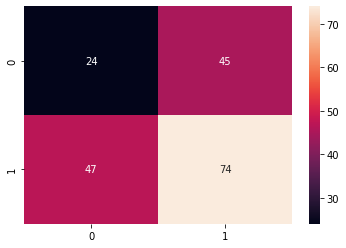

In [34]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns

probabilities=net_final_VGG.predict_generator(generator=valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(probabilities, axis=1)

print('Confusion Matrix')
cm= confusion_matrix(valid_generator.classes, y_pred)
sns.heatmap(cm, annot=True)





In [35]:

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
f1 = f1_score(y_true, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

specificity: 0.3478
sensitivity: 0.6116
f1_score: 0.6167


In [36]:
print('Classification Report')
target_names = ['0', '1']
print(classification_report(valid_generator.classes, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.35      0.34        69
           1       0.62      0.61      0.62       121

    accuracy                           0.52       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.52      0.52      0.52       190



**La courbe ROC**
> 
est un tracé du taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (100-spécificité) pour différents points de coupure d'un paramètre. Chaque point de la courbe ROC représente un couple sensibilité/spécificité correspondant à un seuil de décision particulier.

In [37]:
# # calculate precision-recall curve
# from sklearn.metrics import precision_recall_curve, roc_curve 
# precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# #create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


In [38]:
# from sklearn.metrics import roc_curve, plot_roc_curve   

# def plot_roc_cur(fper, tper):  
#     plt.plot(fper, tper, color='orange', label='ROC')
#     plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend()
#     plt.show()

  
# fper, tper, thresholds = roc_curve(y_true, y_pred) 
# plot_roc_curve(fper, tper)



In [39]:
# layers = [(layer, layer.name, layer.trainable) for layer in net_final.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


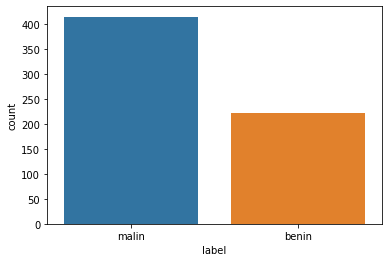

In [40]:
sns.countplot(df_train['label'],data=df_train["label"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


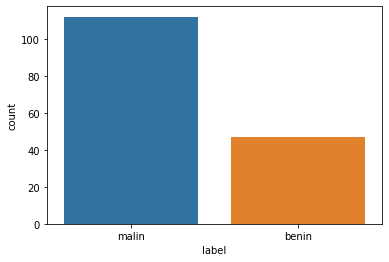

In [41]:
sns.countplot(df_test['label'],data=df_test["label"])


**Les courbes**

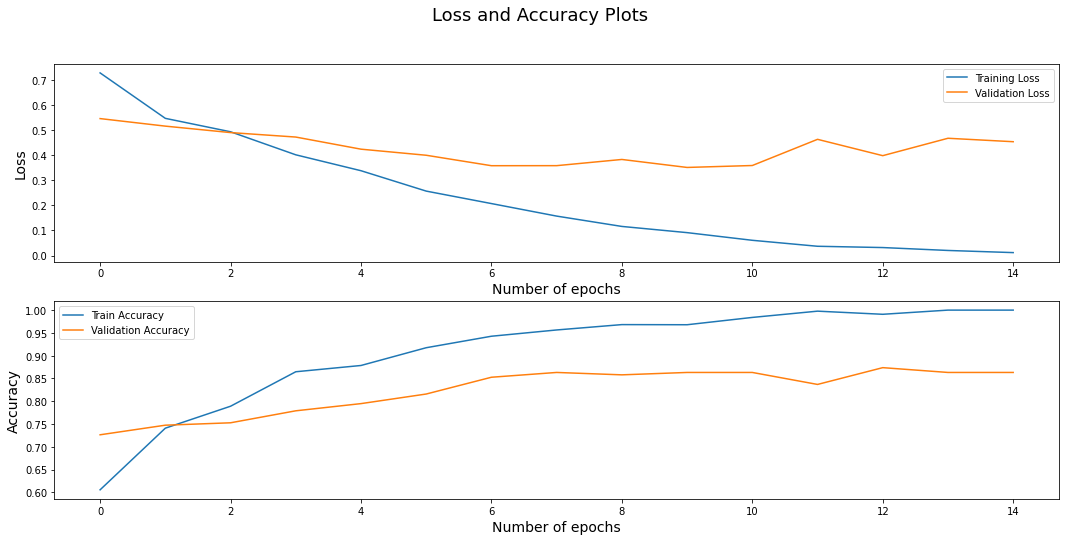

In [42]:
# Les courbes accuracy et Loss
plt.figure(figsize=(18,8)) 
plt.suptitle('Loss and Accuracy Plots', fontsize=18) 
plt.subplot(211)

plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Loss', fontsize=14) 

plt.subplot(212)

plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Accuracy', fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


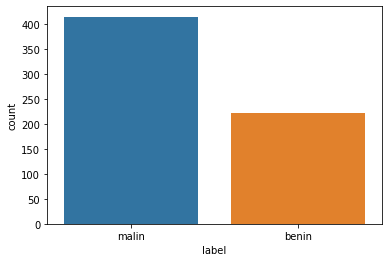

In [43]:
sns.countplot(df_train['label'],data=df_train["label"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


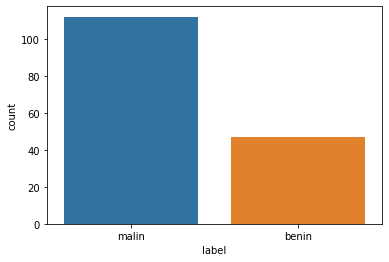

In [44]:
sns.countplot(df_test['label'],data=df_test["label"])


**EVALUTION DES IMAGES DE TEST** 

In [45]:
# s=0

# for i in range(len(testLabels)):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"

#     if label!=testLabels[i]:
#       s=s+1


In [46]:
# print(s,len(testImages))

In [47]:
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

# for i, ax in enumerate(axes.flat):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"
    
#     ax.imshow(image)
#     ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
# fig.tight_layout()    
# plt.show()

**La courbe ROC**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


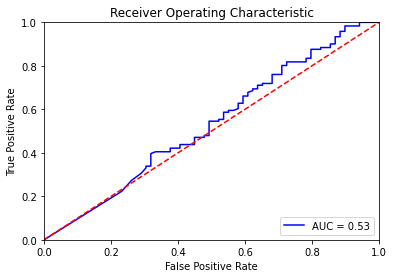

In [48]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probsvgg = net_final_VGG.predict_generator(generator= valid_generator)
predsvgg = probsvgg[:,1]
fprvgg, tprvgg, threshold = metrics.roc_curve(valid_generator.classes, predsvgg)
roc_aucvgg = metrics.auc(fprvgg, tprvgg)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprvgg, tprvgg, 'b', label = 'AUC = %0.2f' % roc_aucvgg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:
# # Vérifiez les résultats sur quelques images sélectionnées
# import cv2 as cv
# n=np.random.randint(0, testImages.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
# img = testImages[n]
# img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    
# score=net_final.predict(input_img)

# if score[0][0] > score[0][1]:
#     print("La prédiction pour cette image est: benin")
# else:
#     print("La prédiction pour cette image est: malin")

# print("L'étiquette réelle de cette image est: ", testLabels[n])

In [50]:
# test_img_path = [] 
# for directory_path in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/*'):
#     Labl = directory_path.split("/")[-1]
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         test_img_path.append(img_path)


In [51]:
# nom_img = []
# test_img_path = np.array(test_img_path)
# n= test_img_path.shape[0]

# for i in range(0,n):
#    nom = test_img_path[i]
#    nom=nom.replace('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/','')
#    nom_img.insert(n,nom)

# print(nom_img)

In [52]:
# directory_path ='/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/*'
# testImage = []
# for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
  
#         testImage.append(img_path)


In [53]:
# # Vérifiez les résultats sur toutes les images de test 
# import shutil
# #complex_dir = "/content/drive/MyDrive/PFEMaster2/BDDMalPredVGGMLP/" # Dossier qui va contenir les images de test mal prédites (Complexes)
# #notcomplex_dir = "/content/drive/MyDrive/PFEMaster2/BDDBienPredVGGMLP/" # Dossier qui va contenir les images de test prédites correctement (Non complexes) 

# dataName= []
# dataPredict= []
# dataLabel=[]

# complexName= []
# complexPredict=[]
# complexLabel=[]

# notComplexName=[]
# notComplexPredict=[]
# notComplexLabel=[]


# n= testImages.shape[0]
# print(n)

# for i in range(0, n):
#   img = testImages[i]
#   input_img = np.expand_dims(image, axis=1) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#   score=net_final.predict(input_img)
#   nom = nom_img[i]



#   if score[0][0] > score[0][1]:
#      dataName.append(nom)
#      dataPredict.append('benin')
#      dataLabel.append(testLabels[i])

#      if 'benin' != testLabels[i]:

#       complexName.append(nom)
#       complexPredict.append('benin')
#       complexLabel.append(testLabels[i])

#      else:

#        notComplexName.append(nom)
#        notComplexPredict.append('benin')
#        notComplexLabel.append(testLabels[i])

#   else:

#       dataName.append(nom)
#       dataPredict.append('malin')
#       dataLabel.append(testLabels[i])

#       if 'malin' != testLabels[i]:

#        complexName.append(nom)
#        complexPredict.append('malin')
#        complexLabel.append(testLabels[i])
      
#       else:

#        notComplexName.append(nom)
#        notComplexPredict.append('malin')
#        notComplexLabel.append(testLabels[i])

# print(dataName, dataPredict, dataLabel) 

In [54]:
# # Create the pandas DataFrame result
# dfResult = pd.DataFrame(dataName,columns = ['Image'])
# dfResult['Prédiction'] = dataPredict
# dfResult['Etiquette réelle'] = dataLabel

# # Create the pandas DataFrame complex
# dfComplex = pd.DataFrame(complexName,columns = ['Image'])
# dfComplex['Prédiction'] = complexPredict
# dfComplex['Etiquette réelle'] = complexLabel

# # Create the pandas DataFrame not complex
# dfNotComplex = pd.DataFrame(notComplexName,columns = ['Image'])
# dfNotComplex['Prédiction'] = notComplexPredict
# dfNotComplex['Etiquette réelle'] = notComplexLabel


In [55]:
# import pandas
# pandas.set_option('display.max_rows', None)
# display(dfComplex)

In [56]:
# display(dfNotComplex)

## VGG-16 (RF)  

### **RF** 

In [57]:

SIZE = 224  #Resize images

# Préparation des données d'entraînement et les étiquettes dans les listes respectives
trainImages = []
trainLabels = [] 

for directory_path in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/*'):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        image = cv2.resize(image, (SIZE, SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        trainImages.append(image)
        trainLabels.append(label)

In [58]:
#Convertir les listes en arrays 
       
trainImages = np.array(trainImages)
trainLabels = np.array(trainLabels)

In [59]:

# Préparation des données de test et les étiquettes dans les listes respectives

testImages = []
testLabels = [] #Contient le nom du dossier(malin et benin)
test_img_path = [] 
for directory_path in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/*'):
    labl = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (SIZE, SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        testImages.append(image)
        testLabels.append(labl)
        test_img_path.append(img_path)

In [60]:

nom_img = []
test_img_path = np.array(test_img_path)
n= test_img_path.shape[0]

for i in range(0,n):
   nom = test_img_path[i]
   nom=nom.replace('content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/','')
   nom_img.insert(n,nom)

print(nom_img)


['/malin/maling.4A_13.jpg', '/malin/maling.4A_14.jpg', '/malin/maling.4A_15.jpg', '/malin/maling.4A_16.jpg', '/malin/maling.4A_22.jpg', '/malin/maling.4A_23.jpg', '/malin/maling.4A_24.jpg', '/malin/maling.4A_25.jpg', '/malin/maling.4A_31.jpg', '/malin/maling.4A_32.jpg', '/malin/maling.4A_33.jpg', '/malin/maling.4A_34.jpg', '/malin/maling.4A_35.jpg', '/malin/maling.4A_36.jpg', '/malin/maling.4A_37.jpg', '/malin/maling.4A_38.jpg', '/malin/maling.4A_39.jpg', '/malin/maling.4A_4.jpg', '/malin/maling.4A_40.jpg', '/malin/maling.4A_41.jpg', '/malin/maling.4A_42.jpg', '/malin/maling.4A_43.jpg', '/malin/maling.4A_45.jpg', '/malin/maling.4A_46.jpg', '/malin/maling.4A_47.jpg', '/malin/maling.4A_48.jpg', '/malin/maling.4A_49.jpg', '/malin/maling.4A_5.jpg', '/malin/maling.4A_50.jpg', '/malin/maling.4A_51.jpg', '/malin/maling.4A_52.jpg', '/malin/maling.4A_53.jpg', '/malin/maling.4A_55.jpg', '/malin/maling.4A_56.jpg', '/malin/maling.4A_57.jpg', '/malin/maling.4A_58.jpg', '/malin/maling.4A_59.jpg', '/

In [61]:
nom_img = np.array(nom_img)

print(nom_img)

['/malin/maling.4A_13.jpg' '/malin/maling.4A_14.jpg'
 '/malin/maling.4A_15.jpg' '/malin/maling.4A_16.jpg'
 '/malin/maling.4A_22.jpg' '/malin/maling.4A_23.jpg'
 '/malin/maling.4A_24.jpg' '/malin/maling.4A_25.jpg'
 '/malin/maling.4A_31.jpg' '/malin/maling.4A_32.jpg'
 '/malin/maling.4A_33.jpg' '/malin/maling.4A_34.jpg'
 '/malin/maling.4A_35.jpg' '/malin/maling.4A_36.jpg'
 '/malin/maling.4A_37.jpg' '/malin/maling.4A_38.jpg'
 '/malin/maling.4A_39.jpg' '/malin/maling.4A_4.jpg'
 '/malin/maling.4A_40.jpg' '/malin/maling.4A_41.jpg'
 '/malin/maling.4A_42.jpg' '/malin/maling.4A_43.jpg'
 '/malin/maling.4A_45.jpg' '/malin/maling.4A_46.jpg'
 '/malin/maling.4A_47.jpg' '/malin/maling.4A_48.jpg'
 '/malin/maling.4A_49.jpg' '/malin/maling.4A_5.jpg'
 '/malin/maling.4A_50.jpg' '/malin/maling.4A_51.jpg'
 '/malin/maling.4A_52.jpg' '/malin/maling.4A_53.jpg'
 '/malin/maling.4A_55.jpg' '/malin/maling.4A_56.jpg'
 '/malin/maling.4A_57.jpg' '/malin/maling.4A_58.jpg'
 '/malin/maling.4A_59.jpg' '/malin/maling.4A_60.

In [62]:
#Convertir les listes en arrays                
testImages = np.array(testImages)
testLabels = np.array(testLabels)
print(testImages)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  4   4   4]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  9   9   9]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  5   5   5]
   [131 131 131]
   [  2   2   2]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  4   4   4]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  9   9   9]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  5   5   5]
   [131 131 131]
   [  2   2

In [63]:
from sklearn import preprocessing
#Encodez les étiquettes de texte en nombres entiers 
labelEnc = preprocessing.LabelEncoder()
labelEnc.fit(testLabels)
testLabelsEncoded = labelEnc.transform(testLabels)
labelEnc.fit(trainLabels)
trainLabelsEncoded = labelEnc.transform(trainLabels)
print(testLabelsEncoded)

x_train = trainImages
y_train = trainLabelsEncoded
x_test = testImages 
y_test = testLabelsEncoded
print(x_test)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  4   4   4]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  3   3   3]
   [  9   9   9]
   [  4   4   4]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  5   5   5]
   [131 131 131]
   [  2   2   2]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0

In [64]:
###################################################################
# Normaliser les valeurs de pixel entre 0 et 1 en divisant chaque valeur de pixel par 255

x_train, x_test = x_train / 255.0, x_test / 255.0

#Un encode à chaud pour les valeurs y pour le réseau de neurones.
from tensorflow.keras.utils import to_categorical
y_trainOneHot = to_categorical(y_train)
y_testOneHot = to_categorical(y_test)


**LES DIFFERENTS NIVEAUX DE FINE TUNING**

**Importer le fichier contenant les poids du VGG-16 entraîné sur des images radiographique COVID-19** 

**1 - poids vgg (train le 5ème bloc de convolution sur des images radiograpique)**


In [65]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
load_path='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/vgg16_model_trained_covid19_TOUSLESBLOC.h5'     
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model_RF = VGG16(include_top=False,weights=None)
base_model_RF.load_weights(load_path,by_name=True)

**2 - poids vgg (train le 4ème et 5ème bloc de convolution sur des images radiograpique)**

In [66]:
# # -----------
# # VGG16 pre-entrainé sans le classifier final
# # https://github.com/keras-team/keras/issues/4465
# # -----------
# load_path='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/vgg16_model_trained_covid19_bloc4_5.h5'     
# # Déclaration du modèle VGG16 (sans le top qui est le classifier)
# base_model_RF = VGG16(include_top=False)
# base_model_RF.load_weights(load_path,by_name=True)

In [67]:

last = base_model_RF.layers[-1].output
x = Flatten()(last)
base_model_RF= Model(base_model_RF.input, x)


for layer in base_model_RF.layers[:19]:
    layer.trainable = False 
 
# Entrainement des derniers layers de classification
for layer in base_model_RF.layers[19:]:
    layer.trainable = True
# compilation du modele


In [68]:

# compilation du modele
# # compilation du modele
from tensorflow.python.keras.optimizer_v2.adam import Adam
base_model_RF.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(base_model_RF.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**ENTRAINER LE MODEL APRES LE FINE TUNING**

In [69]:
# 22

# Le problème est que la sortie de votre modèle final a une activation linéaire,
#  faisant du modèle une régression, pas un problème de classification. La "précision" 
#  est définie lorsque le modèle classe correctement 
# données selon la classe, mais la "précision" n'est effectivement pas définie pour
#  un problème de régression, en raison de sa propriété continue.

In [70]:
# Nous commençons l'entrainement 
epochs = 25
batch_size = 16
Train = True
# Nous entrainons le modèle 

base_model_RF.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          epochs=epochs)


Epoch 1/25
41/41 [==============================] - 18s 294ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 2/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 3/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 4/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 5/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 6/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000e+00 - val_loss: 7.9775 - val_accuracy: 0.0000e+00
Epoch 7/25
41/41 [==============================] - 7s 170ms/step - loss: 8.0744 - accuracy: 0.0000

**EXTRACTION DES CARACTERISTIQUES EN UTILISANT  VGG 16 ET LES FAIRE PASSER AU CLASSIFIER "RF"**

10 0.6973684210526315
20 0.7763157894736842
30 0.8092105263157895
40 0.7631578947368421
50 0.8092105263157895
60 0.756578947368421
70 0.743421052631579
80 0.7697368421052632
90 0.7697368421052632
100 0.8026315789473685
110 0.7828947368421053
120 0.7697368421052632
130 0.7828947368421053
140 0.7697368421052632
150 0.7960526315789473
160 0.8092105263157895
170 0.7960526315789473
180 0.7960526315789473
190 0.7894736842105263
200 0.8026315789473685
210 0.8026315789473685
220 0.8026315789473685
230 0.8092105263157895
240 0.8026315789473685
250 0.7763157894736842
260 0.7894736842105263
270 0.7894736842105263
280 0.8026315789473685
290 0.7697368421052632
300 0.8092105263157895


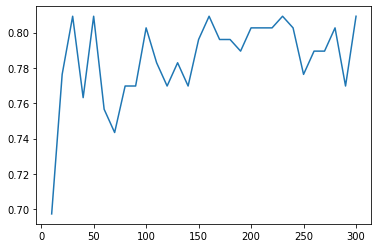

In [71]:

# Maintenant, utilisons les fonctionnalités du réseau convolutif pour RF
# Nous avons besoin d'envoyer nos données d'entrées via l'extracteur de carac vgg16

# featureExtractor=base_model_RF.predict(x_train) # x serait de forme (256*256*3)

# features = featureExtractor.reshape(featureExtractor.shape[0], -1) # featureExtractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512)

# X_for_RF = features # Ceci est notre entrée X à RF

# # # Foret aléatoire
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 100, oob_score = True ,n_jobs = 1,random_state =50)

# # # # Entraîner le modèle sur les données d'entraînement
# RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
N = 30
accuracy = []

for i in range(N):

  
    featureExtractor=base_model_RF.predict(x_train) # x serait de forme (256*256*3)

    features = featureExtractor.reshape(featureExtractor.shape[0], -1) # featureExtractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512) 

    X_for_RF = features # Ceci est notre entrée X à RF
   
    clf = RandomForestClassifier(n_estimators=(i+1)*10 )
    clf.fit(X_for_RF, y_train)
    X_test_feature =  base_model_RF.predict(x_test)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Prédisez maintenant à l'aide du modèle RF entraîné.
    prediction_RF = clf.predict(X_test_features)
# Inversez labelEnc transform pour récupérer l'étiquette d'origine (text).
    prediction_RF = labelEnc.inverse_transform(prediction_RF)


    accuracy.append(metrics.accuracy_score(testLabels, prediction_RF))
    # accuracy.append(clf.score(testLabels,prediction_RF))
    print((i+1)*10, accuracy[i])

plt.plot([10*(i+1) for i in range(N)], accuracy)
plt.show()



In [74]:

# Envoyer les données de test via le même processus d'extraction de caractéristiques
X_test_feature =  base_model_RF.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Prédisez maintenant à l'aide du modèle RF entraîné.
prediction_RF = clf.predict(X_test_features)
# Inversez labelEnc transform pour récupérer l'étiquette d'origine (text).
prediction_RF = labelEnc.inverse_transform(prediction_RF)


**CALCULER LA PRECISION**

In [75]:
# Accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(testLabels, prediction_RF))


Accuracy =  0.8092105263157895


**MATRICE DE CONFUSION**

In [76]:
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(testLabels, prediction_RF)
# sns.heatmap(cm, annot = True) 

# tp, fp, fn, tn = cm.ravel()

# recall = tp/(tp+fn)
# precision = tp/(tp+fp)

# print('Accuracy =', metrics.accuracy_score(testLabels, prediction_RF))
# print("Recall =", recall)
# print("Precision =", precision)




Matrice de confusion


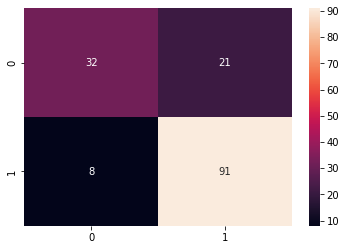

In [77]:

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

cm = confusion_matrix(testLabels, prediction_RF)
print("Matrice de confusion")
sns.heatmap(cm, annot=True)



In [78]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
y_pred = clf.predict(X_test_features)
f1 = f1_score(y_test, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity
# print(cm)
print("accuracy: {:.4f}".format(acc))
print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

accuracy: 0.8092
specificity: 0.6038
sensitivity: 0.9192
f1_score: 0.8626


**La courbe ROC**

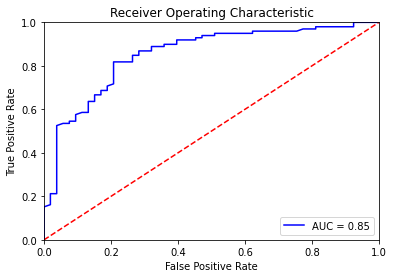

In [79]:
import sklearn.metrics as metrics

probsRF = clf.predict_proba(X_test_features)

predsRF = probsRF[:,1]
fprRF, tprRF, threshold = metrics.roc_curve(y_test, predsRF)
roc_aucRF = metrics.auc(fprRF, tprRF)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprRF, tprRF, 'b', label = 'AUC = %0.2f' % roc_aucRF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**Vérifiez les résultats sur quelques images sélectionnées**

La prédiction pour cette image est:  ['benin']
L'étiquette réelle de cette image est:  malin


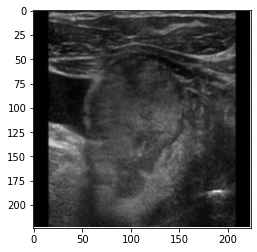

In [81]:
# Vérifiez les résultats sur quelques images sélectionnées
n=np.random.randint(0, x_test.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
image = x_test[n]
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
input_img_feature = base_model_RF.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = clf.predict(input_img_features)[0] 
prediction_RF = labelEnc.inverse_transform([prediction_RF])  # Inverser l'encodeur d'étiquette au nom d'origine
print("La prédiction pour cette image est: ", prediction_RF)
print("L'étiquette réelle de cette image est: ", testLabels[n])

In [ ]:
# # Vérifiez les résultats sur quelques images sélectionnées
# # n=np.random.randint(0, x_test.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
# image = x_test[275]
# plt.imshow(image)
# input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
# input_img_feature=VGG_model.predict(input_img)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
# prediction = RF_model.predict(input_img_features)[0] 
# prediction = labelEnc.inverse_transform([prediction])  # Inverser l'encodeur d'étiquette au nom d'origine
# print("La prédiction pour cette image est: ", prediction)
# print("L'étiquette réelle de cette image est: ", testLabels[275 ])

In [ ]:
# n= x_test.shape[0]
# prediction_images = []
# dataName= []
# dataPredict= []
# dataLabel=[]

# for i in range(0, n):
#   image = x_test[i]
#   input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#   input_img_feature=VGG_model.predict(input_img)
#   input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
#   prediction_SVM = RF_model.predict(input_img_features)[0] 
#   prediction_SVM = labelEnc.inverse_transform([prediction_SVM])  # Inverser l'encodeur d'étiquette au nom d'origin
#   nom = nom_img[i]
#   dataName.append(nom)
#   dataPredict.append(prediction_SVM)
#   dataLabel.append(testLabels[i])

# print(dataName, dataPredict, dataLabel) 

In [ ]:
# # Create the pandas DataFrame
# dfResult = pd.DataFrame(dataName,columns = ['Image'])
# dfResult['Prédiction'] = dataPredict
# dfResult['Etiquette réelle'] = dataLabel
# # display(dfResult)

In [ ]:
# import pandas
# pandas.set_option('display.max_rows', None)

# # pandas.set_option('display.max_rows', dfResult.shape[0]+1)
# display(dfResult)

In [ ]:
# directory_path ='/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/*'
# testImage = []
# for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
  
#         testImage.append(img_path)

In [ ]:
# import shutil
# complexName= []
# complexPredict=[]
# complexLabel=[]

# notComplexName=[]
# notComplexPredict=[]
# notComplexLabel=[]

# # complex_dir_pour_VGG = "/content/drive/MyDrive/PFEMaster2/BDDMalPredVGGRF/" # Dossier qui va contenir les images de test mal prédites (Complexes)
# # notcomplex_dir_pour_VGG = "/content/drive/MyDrive/PFEMaster2/BDDBienPredVGGRF/" # Dossier qui va contenir les images de test prédites correctement (Non complexes) 

# dossier_non_predie = []

# for i in range (0,n):
#   a = dataPredict[i]
#   b = dataLabel [i]
#   c = dataName [i]
#   if a !=	b :
   
#    complexName.append(c)
#    complexPredict.append(a)
#    complexLabel.append(b)

#   else:
   
#    notComplexName.append(c)
#    notComplexPredict.append(a)
#    notComplexLabel.append(b)
 
    

In [ ]:
# # Create the pandas DataFrame complex
# dfComplex = pd.DataFrame(complexName,columns = ['Image'])
# dfComplex['Prédiction'] = complexPredict
# dfComplex['Etiquette réelle'] = complexLabel

# # Create the pandas DataFrame not complex
# dfNotComplex = pd.DataFrame(notComplexName,columns = ['Image'])
# dfNotComplex['Prédiction'] = notComplexPredict
# dfNotComplex['Etiquette réelle'] = notComplexLabel

**Images complexes**

In [ ]:
# display(dfComplex)

**Images non complexes**

In [ ]:
# display(dfNotComplex)

## VGG-16 (SVM)  

### SVM 

**Importer le fichier contenant les poids du VGG-16 entraîné sur des images radiographique COVID-19** 

**1 - poids vgg (train le 5ème bloc de convolution sur des images radiograpique)**

In [82]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
load_path='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/vgg16_model_trained_covid19_TOUSLESBLOC.h5'     
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model_SVM = VGG16(include_top=False,weights=None)
base_model_SVM.load_weights(load_path,by_name=True)

**2 - poids vgg (train le 4ème et 5ème bloc de convolution sur des images radiograpique)**

In [83]:
# # -----------
# # VGG16 pre-entrainé sans le classifier final
# # https://github.com/keras-team/keras/issues/4465
# # -----------
# load_path='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/vgg16_model_trained_covid19_bloc4_5.h5'     
# # Déclaration du modèle VGG16 (sans le top qui est le classifier)
# base_model_SVM = VGG16(include_top=False)
# base_model_SVM.load_weights(load_path,by_name=True)

In [84]:

last = base_model_SVM.layers[-1].output
x = Flatten()(last)
base_model_SVM= Model(base_model_SVM.input, x)


for layer in base_model_SVM.layers[:15]:
    layer.trainable = False 
 
# Entrainement des derniers layers de classification
for layer in base_model_SVM.layers[15:]:
    layer.trainable = True
# compilation du modele

#     layer.trainable = True


In [85]:

# compilation du modele
base_model_SVM.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(base_model_SVM.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [86]:
# Nous commençons l'entrainement 
epochs = 25
batch_size = 16
Train = True
# Nous entrainons le modèle 

base_model_SVM.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          epochs=epochs)


Epoch 1/25
41/41 [==============================] - 9s 206ms/step - loss: 5.9907 - accuracy: 0.0000e+00 - val_loss: 3.7818 - val_accuracy: 0.0000e+00
Epoch 2/25
41/41 [==============================] - 8s 196ms/step - loss: 2.9725 - accuracy: 0.0000e+00 - val_loss: 2.2882 - val_accuracy: 0.0000e+00
Epoch 3/25
41/41 [==============================] - 8s 195ms/step - loss: 2.0103 - accuracy: 0.0000e+00 - val_loss: 1.6718 - val_accuracy: 0.0000e+00
Epoch 4/25
41/41 [==============================] - 8s 196ms/step - loss: 1.4997 - accuracy: 0.0000e+00 - val_loss: 1.2751 - val_accuracy: 0.0000e+00
Epoch 5/25
41/41 [==============================] - 8s 195ms/step - loss: 1.1834 - accuracy: 0.0000e+00 - val_loss: 1.0516 - val_accuracy: 0.0000e+00
Epoch 6/25
41/41 [==============================] - 8s 195ms/step - loss: 1.0111 - accuracy: 0.0000e+00 - val_loss: 0.9510 - val_accuracy: 0.0000e+00
Epoch 7/25
41/41 [==============================] - 8s 196ms/step - loss: 0.9227 - accuracy: 0.0000e

In [89]:
# Maintenant, utilisons les fonctionnalités du réseau convolutif pour RF
# Nous avons besoin d'envoyer nos données d'entrées via l'extracteur de carac vgg16

feature_extractor=base_model_SVM.predict(x_train) # x serait de forme (256*256*3)

features = feature_extractor.reshape(feature_extractor.shape[0], -1) # feature_extractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512)

X_for_SVM = features # Ceci est notre entrée X à RF

# # Foret aléatoire
from sklearn import svm
SVM_model = svm.SVC(kernel='rbf',gamma=0.001,probability=True)
# Entraîner le modèle sur les données d'entraînement
SVM_model.fit(X_for_SVM, y_train) #For sklearn no one hot encoding

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

**LA PREDICTION DU SVM**

In [90]:
# Envoyer les données de test via le même processus d'extraction de caractéristiques
X_test_feature = base_model_SVM.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
# maintenant à l'aide du modèle RF entraîné.
prediction_SVM = classifier.predict(X_test_features)
# Inversez labelEnc transform pour récupérer l'étiquette d'origine (text).
prediction_SVM = labelEnc.inverse_transform(prediction_SVM)


**CALCULER LA PRECISION**

In [91]:
# Accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(testLabels, prediction_SVM))


Accuracy =  0.7763157894736842


**MATRICE DE CONFUSION**

In [92]:
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, prediction_SVM)
# sns.heatmap(cm, annot = True) 

# tp, fp, fn, tn = cm.ravel()

# recall = tp/(tp+fn)
# precision = tp/(tp+fp)

# print('Accuracy =', metrics.accuracy_score(test_labels, prediction_SVM))
# print("Recall =", recall)
# print("Precision =", precision)



Matrice de confusion


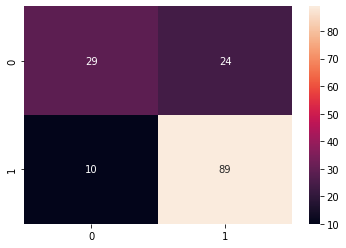

In [93]:

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

cm = confusion_matrix(testLabels, prediction_SVM)
print("Matrice de confusion")
sns.heatmap(cm, annot=True)



In [94]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
y_pred = classifier.predict(X_test_features)
f1 = f1_score(y_test, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

[[29 24]
 [10 89]]
acc: 0.7763
specificity: 0.5472
sensitivity: 0.8990
f1_score: 0.8396


**La courbe ROC**

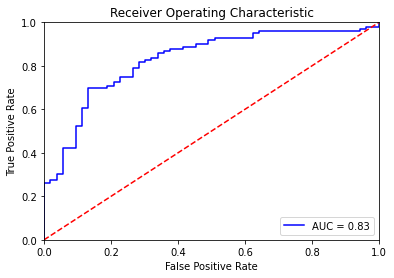

In [95]:
import sklearn.metrics as metrics


probsSVM = classifier.predict_proba(X_test_features)

predsSVM = probsSVM[:,1]
fprSVM, tprSVM, threshold = metrics.roc_curve(y_test, predsSVM)
roc_aucSVM = metrics.auc(fprSVM, tprSVM)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprSVM, tprSVM, 'b', label = 'AUC = %0.2f' % roc_aucSVM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**La courbe ROC**

In [96]:
# from sklearn.metrics import roc_curve, plot_roc_curve   

# def plot_roc_cur(fper, tper):  
#     plt.plot(fper, tper, color='orange', label='ROC')
#     plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend()
#     plt.show()

  
# fper, tper, thresholds = roc_curve(y_true, y_pred) 
# plot_roc_curve(classifier,fper, tper)

**Vérifiez les résultats sur quelques images sélectionnées**

In [ ]:
# # Vérifiez les résultats sur quelques images sélectionnées
# n=np.random.randint(0, x_test.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
# # image = x_test[275 ]
# image = x_test[n]
# plt.imshow(image)
# input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
# input_img_feature=base_model_SVM.predict(input_img)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
# prediction_SVM = classifier.predict(input_img_features)[0] 
# prediction_SVM = labelEnc.inverse_transform([prediction_SVM])  # Inverser l'encodeur d'étiquette au nom d'origine
# print("La prédiction pour cette image est: ", prediction_SVM)
# print("L'étiquette réelle de cette image est: ", testLabels[n])

In [ ]:
# n= x_test.shape[0]
# prediction_images = []
# dataName= []
# dataPredict= []
# dataLabel=[]

# for i in range(0, n):
#   image = x_test[i]
#   input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#   input_img_feature=VGG_model.predict(input_img)
#   input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
#   prediction_SVM = classifier.predict(input_img_features)[0] 
#   prediction_SVM = labelEnc.inverse_transform([prediction_SVM])  # Inverser l'encodeur d'étiquette au nom d'origin
#   nom = nom_img[i]
#   dataName.append(nom)
#   dataPredict.append(prediction_SVM)
#   dataLabel.append(testLabels[i])

# print(dataName, dataPredict, dataLabel) 

In [ ]:
# # Create the pandas DataFrame
# dfResult = pd.DataFrame(dataName,columns = ['Image'])
# dfResult['Prédiction'] = dataPredict
# dfResult['Etiquette réelle'] = dataLabel
# # display(dfResult)

In [ ]:
# import pandas
# pandas.set_option('display.max_rows', None)

# # pandas.set_option('display.max_rows', dfResult.shape[0]+1)
# display(dfResult)

In [ ]:
# directory_path ='/content/drive/MyDrive/PFEMaster2/les2BDD/test/*'
# testImage = []
# for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
  
#         testImage.append(img_path)

In [ ]:
# import shutil
# complexName= []
# complexPredict=[]
# complexLabel=[]

# notComplexName=[]
# notComplexPredict=[]
# notComplexLabel=[]

# complex_dir_pour_VGG = "/content/drive/MyDrive/PFEMaster2/BDDMalPredVGGSVM/" # Dossier qui va contenir les images de test mal prédites (Complexes)
# notcomplex_dir_pour_VGG = "/content/drive/MyDrive/PFEMaster2/BDDBienPredVGGSVM/" # Dossier qui va contenir les images de test prédites correctement (Non complexes) 

# dossier_non_predie = []

# for i in range (0,n):
#   a = dataPredict[i]
#   b = dataLabel [i]
#   c = dataName [i]
#   if a !=	b :
#    shutil.copy(testImage[i], complex_dir_pour_VGG)
#    complexName.append(c)
#    complexPredict.append(a)
#    complexLabel.append(b)

#   else:
#    shutil.copy(testImage[i], notcomplex_dir_pour_VGG) # Copier l'image à un autre dossier
#    notComplexName.append(c)
#    notComplexPredict.append(a)
#    notComplexLabel.append(b)
 
    

In [ ]:
# # Create the pandas DataFrame complex
# dfComplex = pd.DataFrame(complexName,columns = ['Image'])
# dfComplex['Prédiction'] = complexPredict
# dfComplex['Etiquette réelle'] = complexLabel

# # Create the pandas DataFrame not complex
# dfNotComplex = pd.DataFrame(notComplexName,columns = ['Image'])
# dfNotComplex['Prédiction'] = notComplexPredict
# dfNotComplex['Etiquette réelle'] = notComplexLabel


**Images complexes**

In [ ]:
# display(dfComplex)

**Images non complexes**

In [ ]:
# display(dfNotComplex)

# **Resnet50V2  code (avec les poids des images radiographique pneumonia)** 








**Importer les packages nécessaire pour Resnet50V2 + la Construction du MLP**

In [120]:

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Transfert** **progressif**  **TP**

**Importer le fichier contenant les poids du  Resnet50V2 entraîner sur des images radiographique** 

**1- poids resnet50v2 train 5ème bloc de convolution sur images de pneumonia**

In [121]:
import tensorflow as tf

# C pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
load_pathRSN='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_resnet50v2_TPr/poid_resnet_tou_le_bloc_conv.h5'    
# Déclaration du modèle RESNET (sans le top qui est le classifier)

base_model_RS= tf.keras.applications.ResNet50V2( include_top=False,input_shape=(224, 224, 3), weights=None)

# base_model.load_weights(load_pathRSN,by_name=True)


## Resnet50V2 (MLP)  

**Model final (Resnet50V2 + MLP )** **& Fine-tuning** 

In [132]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
x = base_model_RS.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dense(128, activation='relu', name='top-fc3')(x)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(4, activation='softmax', name='softmax')(x)
# Assemblage du modèle final
net_final_RS = Model(inputs=base_model_RS.input, outputs=output_layer)

In [133]:
net_final_RS.load_weights(load_pathRSN,by_name=True)

In [134]:
net_final_RS.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [135]:
net_final_RS = Model(inputs=net_final_RS.input, outputs= net_final_RS.get_layer('top-fc3').output)

In [136]:
print(net_final_RS.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [137]:
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final_RS = Model(inputs=net_final_RS.input, outputs=output_layer)

In [138]:
net_final_RS.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [139]:
layers = [(layer, layer.name, layer.trainable) for layer in net_final_RS.layers]
pd.set_option("max_rows",243 
              )
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D obje...,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0...,pool1_pool,False
5,<keras.layers.normalization.batch_normalizatio...,conv2_block1_preact_bn,False
6,<keras.layers.core.Activation object at 0x7f05...,conv2_block1_preact_relu,False
7,<keras.layers.convolutional.Conv2D object at 0...,conv2_block1_1_conv,False
8,<keras.layers.normalization.batch_normalizatio...,conv2_block1_1_bn,False
9,<keras.layers.core.Activation object at 0x7f05...,conv2_block1_1_relu,False


In [140]:

for layer in net_final_RS.layers[:154]:
   layer.trainable = False 

# Entrainement des derniers layers de classification
for layer in net_final_RS.layers[154:]:
    layer.trainable = True

# compilation du modele

net_final_RS.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(net_final_RS.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [141]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size 
print(STEP_SIZE_TRAIN)
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size 
print(STEP_SIZE_VALID)
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size
print(STEP_SIZE_TEST)


44
19
159


**TRAIN**

In [142]:

# model_savepath    = '/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/cnn_resnet50_model_trained_2.h5' 
# if (TRAIN):
    
    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    #checkpoint = ModelCheckpoint("/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_resnet50v2_TPr/modelresnet50.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    #   pour arrêt prématuré
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
history = net_final_RS.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early],
                    epochs = EPOCH)
    
#     # Sauvegarde du réseau après entrainement
#     net_final.save(model_savepath)    
    
# else:
#     net_final.load_weights(model_savepath)   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
44/44 [==============================] - 16s 225ms/step - loss: 0.7953 - accuracy: 0.6055 - val_loss: 0.6069 - val_accuracy: 0.6947
Epoch 2/80
44/44 [==============================] - 8s 172ms/step - loss: 0.5228 - accuracy: 0.7615 - val_loss: 0.5786 - val_accuracy: 0.7316
Epoch 3/80
44/44 [==============================] - 7s 170ms/step - loss: 0.4097 - accuracy: 0.8463 - val_loss: 0.5299 - val_accuracy: 0.7316
Epoch 4/80
44/44 [==============================] - 7s 170ms/step - loss: 0.3132 - accuracy: 0.9128 - val_loss: 0.4929 - val_accuracy: 0.7421
Epoch 5/80
44/44 [==============================] - 8s 170ms/step - loss: 0.2066 - accuracy: 0.9679 - val_loss: 0.4804 - val_accuracy: 0.7526
Epoch 6/80
44/44 [==============================] - 8s 171ms/step - loss: 0.1589 - accuracy: 0.9587 - val_loss: 0.4581 - val_accuracy: 0.7684
Epoch 7/80
44/44 [==============================] - 8s 170ms/step - loss: 0.1135 - accuracy: 0.9839 - val_loss: 0.4431 - val_accuracy: 0.7947
Epoch

**EVALUATION DES IMAGES DE VALIDATION (30 % D'IMAGES DE TRAIN)**

**ACCURACY**

In [143]:
net_final_RS.evaluate(valid_generator)[1]

19/19 [==============================] - 2s 85ms/step - loss: 0.4735 - accuracy: 0.8158


0.8157894611358643

**MATRICE DE CONFUSION, SPECIFICITY, SENSITIVITY, SCORE_F1**

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


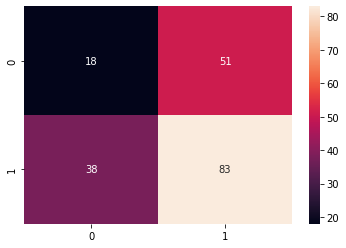

In [144]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns

probabilities=net_final_RS.predict_generator(generator= valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(probabilities, axis=1)

print('Confusion Matrix')
cm= confusion_matrix(valid_generator.classes, y_pred)
sns.heatmap(cm, annot=True)

In [145]:

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
f1 = f1_score(y_true, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

specificity: 0.2609
sensitivity: 0.6860
f1_score: 0.6510


In [146]:
print('Classification Report')
target_names = ['Benin', 'Malin']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Benin       0.32      0.26      0.29        69
       Malin       0.62      0.69      0.65       121

    accuracy                           0.53       190
   macro avg       0.47      0.47      0.47       190
weighted avg       0.51      0.53      0.52       190



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


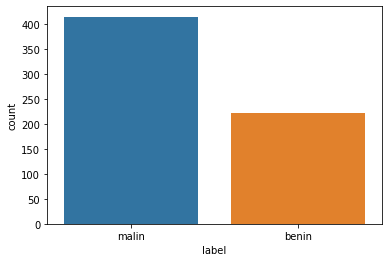

In [147]:
sns.countplot(df_train['label'],data=df_train["label"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


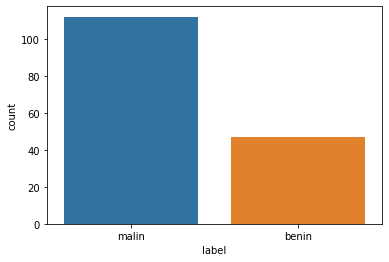

In [148]:
sns.countplot(df_test['label'],data=df_test["label"])


**Les courbes**

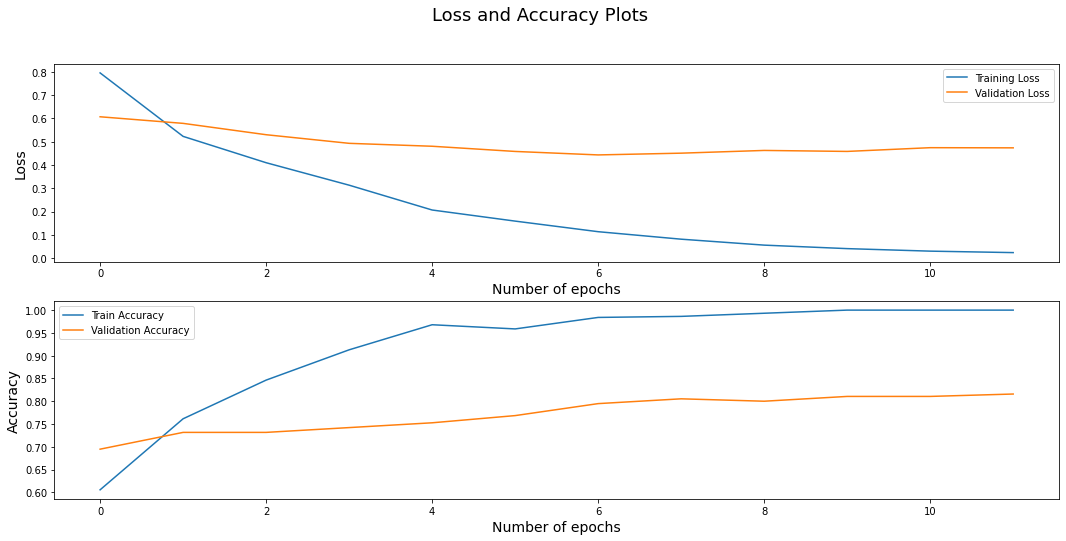

In [149]:
# Les courbes accuracy et Loss
plt.figure(figsize=(18,8)) 
plt.suptitle('Loss and Accuracy Plots', fontsize=18) 
plt.subplot(211)

plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Loss', fontsize=14) 

plt.subplot(212)

plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Accuracy', fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


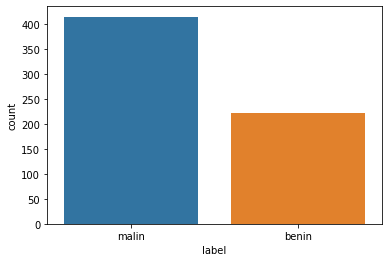

In [150]:
sns.countplot(df_train['label'],data=df_train["label"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


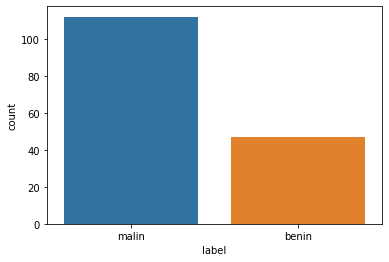

In [151]:
sns.countplot(df_test['label'],data=df_test["label"])


**La courbe ROC**

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


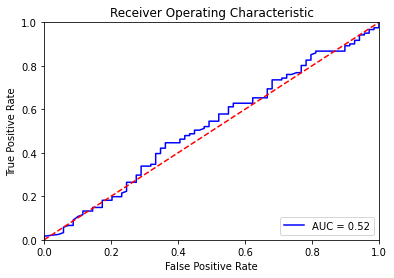

In [152]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probsRS = net_final_RS.predict_generator(generator= valid_generator)
predsRS = probsRS[:,1]
fprRS, tprRS, threshold = metrics.roc_curve(valid_generator.classes, predsRS)
roc_aucRS = metrics.auc(fprRS, tprRS)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprRS, tprRS, 'b', label = 'AUC = %0.2f' % roc_aucRS)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**EVALUTION DES IMAGES DE TEST** 

In [153]:
# s=0

# for i in range(len(testLabels)):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final_RS.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"

#     if label!=testLabels[i]:
#       s=s+1


In [154]:
# print(s,len(testImages))

In [155]:
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

# for i, ax in enumerate(axes.flat):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final_RS.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"
    
#     ax.imshow(image)
#     ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
# fig.tight_layout()    
# plt.show()

In [156]:
# # Vérifiez les résultats sur quelques images sélectionnées
# import cv2 as cv
# n=np.random.randint(0, testImages.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
# img = testImages[n]
# img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
# score=net_final_RS.predict(input_img)
# if score[0][0] > score[0][1]:
#     print("La prédiction pour cette image est: benin")
# else:
#     print("La prédiction pour cette image est: malin")

# print("L'étiquette réelle de cette image est: ", testLabels[n])


# **EfficientNet B0 code (avec les poids des images radiographique covid19)**

**Importer les packages nécessaires pour EfficientNetB0**

In [157]:

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

**Transfert** **progressif**  **TP**

## EfficientNetB0 (MLP)








In [158]:

load_pathEFFI='/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_efficientB0_TPr/effi_model_trained_covid19_LETOUT.h5'  
from tensorflow.keras.applications import EfficientNetB0
base_model_effi = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights=None)

from tensorflow.keras.layers import BatchNormalization

for layer in base_model_effi.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


## EFFI (MLP)  

In [159]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
x = base_model_effi.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dense(128, activation='relu', name='top-fc3')(x)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(4, activation='softmax', name='softmax')(x)
# Assemblage du modèle final
net_final_EFFI = Model(inputs=base_model_effi.input, outputs=output_layer)

In [160]:
net_final_EFFI.load_weights(load_pathEFFI,by_name=True)

In [161]:
net_final_EFFI.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

In [162]:
net_final_EFFI = Model(inputs=net_final_EFFI.input, outputs= net_final_EFFI.get_layer('top-fc3').output)

In [163]:
print(net_final_EFFI.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

In [164]:
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final_EFFI = Model(inputs=net_final_EFFI.input, outputs=output_layer)

In [165]:
net_final_EFFI.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

In [166]:
layers = [(layer, layer.name, layer.trainable) for layer in net_final_EFFI.layers]
pd.set_option("max_rows",243 
              )

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.preprocessing.image_preprocessin...,rescaling,False
2,<keras.layers.preprocessing.normalization.Norm...,normalization,False
3,<keras.layers.convolutional.ZeroPadding2D obje...,stem_conv_pad,False
4,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
5,<keras.layers.normalization.batch_normalizatio...,stem_bn,True
6,<keras.layers.core.Activation object at 0x7f05...,stem_activation,False
7,<keras.layers.convolutional.DepthwiseConv2D ob...,block1a_dwconv,False
8,<keras.layers.normalization.batch_normalizatio...,block1a_bn,True
9,<keras.layers.core.Activation object at 0x7f06...,block1a_activation,False


**Model final (VGG-16 + MLP )** **& Fine-tuning**

In [167]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size 
print(STEP_SIZE_TRAIN)
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size 
print(STEP_SIZE_VALID)
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size
print(STEP_SIZE_TEST)


44
19
159


In [168]:

# Entrainement des derniers layers de classification
for layer in net_final_EFFI.layers[:221]:
    layer.trainable = False 
 
# Entrainement des derniers layers de classification
for layer in net_final_EFFI.layers[221:]:
    layer.trainable = True
# compilation du modele
from tensorflow.keras.optimizers import Adam
net_final_EFFI.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(net_final_EFFI.summary())

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**TRAIN**

In [169]:
# model_savepath    = '/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/cnn_vgg16_model_trained_2.h5' 
# if (TRAIN):
    
    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    #checkpoint = ModelCheckpoint("/content/drive/MyDrive/PFE_M2/transfert_progressif_images_medical/poids_vgg16_TPr/modelvgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    #   pour arrêt prématuré
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
history = net_final_EFFI.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early],
                    epochs = EPOCH)
    
#     #Sauvegarde du réseau après entrainement
#     net_final.save(model_savepath)    
    
# else:
#     net_final.load_weights(model_savepath)   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
44/44 [==============================] - 14s 152ms/step - loss: 0.6441 - accuracy: 0.6628 - val_loss: 0.5984 - val_accuracy: 0.6895
Epoch 2/80
44/44 [==============================] - 5s 105ms/step - loss: 0.5547 - accuracy: 0.7133 - val_loss: 0.5520 - val_accuracy: 0.7211
Epoch 3/80
44/44 [==============================] - 5s 106ms/step - loss: 0.4680 - accuracy: 0.8050 - val_loss: 0.5099 - val_accuracy: 0.7158
Epoch 4/80
44/44 [==============================] - 5s 104ms/step - loss: 0.4423 - accuracy: 0.7913 - val_loss: 0.4772 - val_accuracy: 0.7684
Epoch 5/80
44/44 [==============================] - 5s 103ms/step - loss: 0.4070 - accuracy: 0.8555 - val_loss: 0.4609 - val_accuracy: 0.7842
Epoch 6/80
44/44 [==============================] - 5s 104ms/step - loss: 0.3578 - accuracy: 0.8624 - val_loss: 0.4357 - val_accuracy: 0.7737
Epoch 7/80
44/44 [==============================] - 5s 104ms/step - loss: 0.3265 - accuracy: 0.8945 - val_loss: 0.4218 - val_accuracy: 0.7947
Epoch

**ACCURACY**

In [170]:
net_final_EFFI.evaluate(valid_generator)[1]

19/19 [==============================] - 1s 70ms/step - loss: 0.3792 - accuracy: 0.8263


0.8263157606124878

**MATRIX DE CONFUSION, SPECIFICITY, SENSITIVITY, F1_SCORE**

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


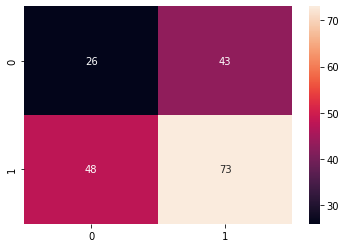

In [171]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns

probabilities=net_final_EFFI.predict_generator(generator=valid_generator)

y_true = valid_generator.classes
y_pred = np.argmax(probabilities, axis=1)

print('Confusion Matrix')
cm= confusion_matrix(valid_generator.classes, y_pred)
sns.heatmap(cm, annot=True)

In [172]:

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
f1 = f1_score(y_true, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

specificity: 0.3768
sensitivity: 0.6033
f1_score: 0.6160


In [173]:
print('Classification Report')
target_names = ['Benin', 'Malin']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Benin       0.35      0.38      0.36        69
       Malin       0.63      0.60      0.62       121

    accuracy                           0.52       190
   macro avg       0.49      0.49      0.49       190
weighted avg       0.53      0.52      0.52       190



In [174]:
# layers = [(layer, layer.name, layer.trainable) for layer in net_final.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [175]:
# sns.countplot(df_train['label'],data=df_train["label"])

In [176]:
# sns.countplot(df_test['label'],data=df_test["label"])
# 

**Les courbes**

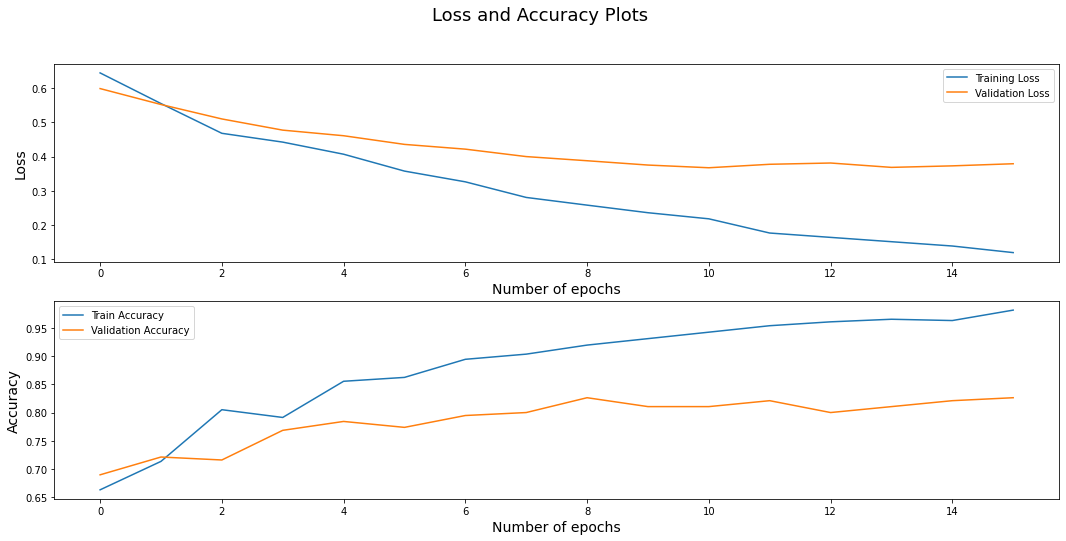

In [177]:
# Les courbes accuracy et Loss
plt.figure(figsize=(18,8)) 
plt.suptitle('Loss and Accuracy Plots', fontsize=18) 
plt.subplot(211)

plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Loss', fontsize=14) 

plt.subplot(212)

plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [178]:
# sns.countplot(df_train['label'],data=df_train["label"])

In [179]:
# sns.countplot(df_test['label'],data=df_test["label"])


**La courbe ROC**

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


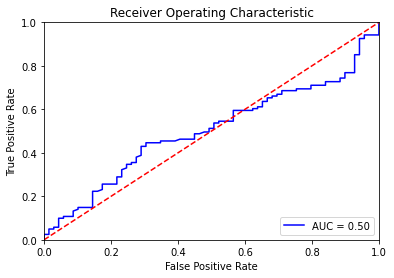

In [180]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probsEFFI = net_final_EFFI.predict_generator(generator= valid_generator)
predsEFFI = probsEFFI[:,1]
fprEFFI, tprEFFI, threshold = metrics.roc_curve(valid_generator.classes, predsEFFI)
roc_aucEFFI = metrics.auc(fprEFFI, tprEFFI)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprEFFI, tprEFFI, 'b', label = 'AUC = %0.2f' % roc_aucEFFI)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



**EVALUTION DES IMAGES DE TEST** 

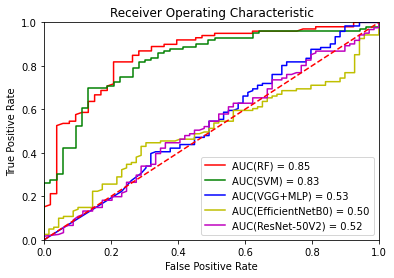

In [181]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprRF,   tprRF, 'r', label = 'AUC(RF) = %0.2f' % roc_aucRF)
plt.plot(fprSVM, tprSVM, 'g', label = 'AUC(SVM) = %0.2f' % roc_aucSVM)
plt.plot(fprvgg, tprvgg, 'b', label = 'AUC(VGG+MLP) = %0.2f' % roc_aucvgg)
plt.plot(fprEFFI, tprEFFI, 'y', label = 'AUC(EfficientNetB0) = %0.2f' % roc_aucEFFI)
plt.plot(fprRS, tprRS, 'm', label = 'AUC(ResNet-50V2) = %0.2f' % roc_aucRS)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [182]:
# s=0

# for i in range(len(testLabels)):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"

#     if label!=testLabels[i]:
#       s=s+1


In [183]:
# print(s,len(testImages))

In [184]:
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

# for i, ax in enumerate(axes.flat):
#     img_path=testImages[i]
#     image = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (224, 224))
#     input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
#     score=net_final_EFFI.predict(input_img)
#     label="" 
#     if score[0][0] > score[0][1]:
#       label= "benin"
#     else:
#       label= "malin"
    
#     ax.imshow(image)
#     ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
# fig.tight_layout()    
# plt.show()

In [185]:
# # Vérifiez les résultats sur quelques images sélectionnées
# import cv2 as cv
# n=np.random.randint(0, testImages.shape[0]) # Générer un nombre dans l'ensemble de test puis charger l'image et appliquez la prédiction pour voir si la prédiction est juste ou fausse
# img = testImages[n]
# img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
# score=net_final.predict(input_img)
# if score[0][0] > score[0][1]:
#     print("La prédiction pour cette image est: benin")
# else:
#     print("La prédiction pour cette image est: malin")

# print("L'étiquette réelle de cette image est: ", testLabels[n])

#Interface

In [186]:
!pip install gradio



     |████████████████████████████████| 3.4 MB 6.0 MB/s 
     |████████████████████████████████| 1.9 MB 35.6 MB/s 
     |████████████████████████████████| 206 kB 47.3 MB/s 
     |████████████████████████████████| 3.5 MB 38.2 MB/s 
     |████████████████████████████████| 961 kB 33.6 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=21afb244cce3933f9b558b513cdc4d673477cf28be642c9307943d7939511787
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=ea3ced2f0e11138907714e3f0a670042b150d5fb75c8fd8ce1faeb75aadc275b
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [188]:
import gradio as gr
gr.reset_all()
def efficientnet_b0(img):
  
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_EFFI.predict(input_img)
    labe="" 
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return "Efficient net B0  : " + labe + "!"

def VGG_16_MLP(img):
    
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_VGG.predict(input_img)
    labe="" 
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return " VGG-16  : " + labe + "!"

def resnet50v2(img):
    
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_RS.predict(input_img)
    labe="" 
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return "Resnet50v2  : " + labe + "!"


def VGG_RF(img):
  testImage = []

  image = cv2.resize(img, (SIZE, SIZE))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  testImage.append(image)
  testImage = np.array(testImage)
  x_test = testImage
  x_test =  x_test / 255.0
  y= x_test[0]
  input_img = np.expand_dims(y, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
  input_img_feature = base_model_RF.predict(input_img)
  input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
  prediction_RF = clf.predict(input_img_features)[0] 
  labe="" 
  if prediction_RF == 0 :
      labe= "lésion bénigne"
  else:
      labe= "lésion maligne "
  return "VGG 16 + Random forest   : " + labe + "!"
 

def VGG_SVM(img):
  testImage = []

  image = cv2.resize(img, (SIZE, SIZE))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  testImage.append(image)
  testImage = np.array(testImage)
  x_test = testImage
  x_test =  x_test / 255.0
  y= x_test[0]
  input_img = np.expand_dims(y, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
  input_img_feature = base_model_SVM.predict(input_img)
  input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
  prediction_svm = classifier.predict(input_img_features)[0] 
  labe="" 
  if prediction_svm == 0 :
      labe= "lésion bénigne"
  else:
      labe= "lésion maligne "
  return "VGG 16 + SVM   : " + labe + "!"
 


io = gr.Interface([efficientnet_b0,VGG_16_MLP,resnet50v2,VGG_RF, VGG_SVM], "image", "label", interpretation="default")
io.test_launch()
io.launch()


Test launch: efficientnet_b0()... PASSED
Test launch: VGG_16_MLP()... PASSED
Test launch: resnet50v2()... PASSED
Test launch: VGG_RF()... PASSED
Test launch: VGG_SVM()... PASSED
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://18943.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://18943.gradio.app')